# 4:Slide-seqV2_Clustering (MOB)

HDVAE can process Slide-SeqV2 data to extract low-dimension representation. In this tutorial, we use MOB dataset to introduce the analysis.

The raw MOB dataset can be downloaded from:https://singlecell.broadinstitute.org/single_cell/study/SCP815/highly-sensitive-spatial-transcriptomics-at-near-cellular-resolution-with-slide-seqv2#study-summary).

barcodes data comes from STAGATE https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing.

The complete experimental dataset is available here https://zenodo.org/records/15599070

## Preparation

In [1]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os

In [2]:
import torch
import HDVAE
HDVAE.fix_seed(2023)

In [3]:
input_dir = '../data/Slide-seq'
counts_file = os.path.join(input_dir, 'Puck_200127_15.digital_expression.txt')
coor_file = os.path.join(input_dir, 'Puck_200127_15_bead_locations.csv')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, index_col="barcode")

In [5]:
adata = sc.AnnData(counts.T)
adata.var_names_make_unique()
coor_df = coor_df.loc[adata.obs_names, ['xcoord', 'ycoord']]
adata.obsm["spatial"] = coor_df.to_numpy()

In [6]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [7]:
used_barcode = pd.read_csv('../data/Slide-seq/used_barcodes.txt', sep='\t', header=None)
used_barcode = used_barcode[0]
adata = adata[used_barcode,]

In [8]:
sc.pp.filter_genes(adata, min_cells=50)

D:\anaonda3\envs\ST_pytorch\Lib\site-packages\scanpy\preprocessing\_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [9]:
#Normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)
sc.pp.log1p(adata)

from sklearn.decomposition import PCA
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

D:\anaonda3\envs\ST_pytorch\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:74: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


## Constructing the spatial network

In [10]:
# construct graph
graph_dict = HDVAE.graph_construction(adata, 12)

E:\HDVAE\HDVAE\graph_func.py:37: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:646.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [11]:
adata

AnnData object with n_obs × n_vars = 20139 × 11750
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'spatial', 'X_pca'

## Running HDVAE

In [12]:
hdvae_net = HDVAE.hdvae(adata.obsm['X_pca'], graph_dict, device=device, gcn_hidden2=12, lambda_sim=0.38)
hdvae_net.train_with_dec()
hdvae_feat, _, _, _ = hdvae_net.process()
adata.obsm['HDVAE'] = hdvae_feat

E:\HDVAE\HDVAE\HDVAE_model.py:74: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  total_idx = torch.range(0, self.cell_num - 1, dtype=torch.float64).to(self.device)
E:\HDVAE\HDVAE\HDVAE_model.py:191: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
D:\anaonda3\envs\ST_pytorch\Lib\site-packages\torch\nn\functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnin

## Clustering

In [13]:
#HDVAE.configure_r_environment()   # If you encounter problems loading R packages, you can manually configure your path in this function.

In [14]:
n_clusters=11
HDVAE.mclust_R(adata, n_clusters=n_clusters, use_rep='HDVAE', key_added='HDVAE_cluster')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 20139 × 11750
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'HDVAE_cluster'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'spatial', 'X_pca', 'HDVAE'

### Visualization

In [15]:
adata.obsm["spatial"] = adata.obsm["spatial"] * (-1)

In [16]:
import matplotlib as mpl
mpl.rcParams.update({
    'font.family': 'Arial',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.titlesize': 12,
    'figure.constrained_layout.use': True
})

mclust_palette = [
    "#F3766E", "#5BB300", "#2E96FF", "#C655D9", "#FFB549",
    "#00C6EA", "#9B8500", "#009E73", "#FF6EB4", "#7AFF33",
    "#A837D8", "#FFD700", "#00FF99", "#FF7F50", "#8A2BE2",
    "#4B0082", "#FF1493", "#32CD32", "#8B4513"
]

C:\Users\Angle\AppData\Local\Temp\ipykernel_50016\162735247.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 400x300 with 0 Axes>

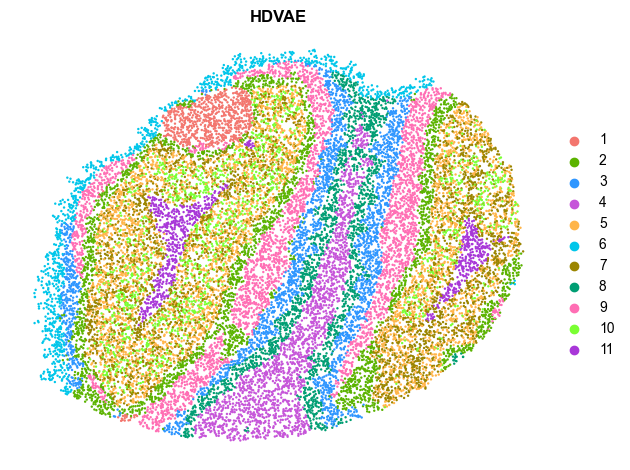

In [17]:
plt.figure(figsize=(4, 3), facecolor='white')
sc.pl.embedding(
    adata,
    basis="spatial",
    color="HDVAE_cluster",
    palette=mclust_palette,
    s=12,
    title=f"HDVAE",
    show=False,
    frameon=False
)
ax = plt.gca()
ax.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
# plt.savefig('Slide_seq_spatial.png',dpi=300, bbox_inches='tight')